<a href="https://colab.research.google.com/github/justlab11/MLTSA22_JLabombard/blob/main/HW8/HW8_JLabombard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
from google.colab import drive
from scipy.interpolate import interp1d
import pylab as pl

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
drive.mount('/content/drive', force_remount=True) # this is because my drive is refusing to update

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/.kaggle

/content/drive/MyDrive/.kaggle


In [4]:
import json
import os

envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [5]:
cd /content/drive/MyDrive/MLTSA22/

/content/drive/MyDrive/MLTSA22


In [6]:
mkdir HW8

mkdir: cannot create directory ‘HW8’: File exists


In [7]:
cd HW8

/content/drive/MyDrive/MLTSA22/HW8


In [8]:
!kaggle competitions download -c PLAsTiCC-2018

100% 13.8G/13.8G [01:47<00:00, 195MB/s]
100% 13.8G/13.8G [01:47<00:00, 137MB/s]


In [9]:
!unzip PLAsTiCC-2018

Archive:  PLAsTiCC-2018.zip
  inflating: data_note.pdf           
  inflating: sample_submission.csv   
  inflating: test_set.csv            
  inflating: test_set_batch1.csv     
  inflating: test_set_batch10.csv    
  inflating: test_set_batch11.csv    
  inflating: test_set_batch2.csv     
  inflating: test_set_batch3.csv     
  inflating: test_set_batch4.csv     
  inflating: test_set_batch5.csv     
  inflating: test_set_batch6.csv     
  inflating: test_set_batch7.csv     
  inflating: test_set_batch8.csv     
  inflating: test_set_batch9.csv     
  inflating: test_set_metadata.csv   
  inflating: test_set_sample.csv     
  inflating: training_set.csv        
  inflating: training_set_metadata.csv  


In [10]:
lcvs = pd.read_csv("training_set.csv")

In [11]:
time_scaled = lcvs.groupby(["object_id", "passband"])["mjd"].apply(lambda x: x-(x.min()))
lcvs["mjd_scaled"] = time_scaled.values

The variable `mjd_scaled` shows `mjd` starting at zero for each bandpass and increasing in number of days. Below shows `mjd` vs `mjd_scaled` for the same band of the same object. `mjd_scaled` starts at 0 due to being scaled by the minimum of `mjd`.

In [12]:
lcvs[lcvs["object_id"]== 615][lcvs[lcvs["object_id"]== 615]["passband"]==2][["mjd", "mjd_scaled"]].head(10)

,mjd,mjd_scaled
0,59750.4229,0.0000
4,59752.4070,1.9841
9,59767.2968,16.8739
14,59770.2179,19.7950
19,59779.3188,28.8959
24,59782.1897,31.7668
29,59797.2861,46.8632
34,59800.3168,49.8939
39,59807.1738,56.7509
44,59810.1045,59.6816


In [13]:
needed_vals = lcvs.groupby(["object_id", "passband"], as_index=False)[["object_id", "passband","mjd_scaled", "flux"]]
sectioned_df = pd.DataFrame(needed_vals)

In [14]:
lerp = []

for i in range(sectioned_df[1].shape[0]):
  x = sectioned_df[1][i]["mjd_scaled"].values
  y = sectioned_df[1][i]["flux"].values
  xnew = np.linspace(0, int(max(x)), num=100, endpoint=True)

  lerp.append(interp1d(x,y, kind="linear")(xnew))

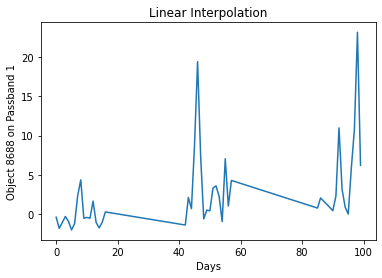

In [15]:
num = 265

id = lcvs["object_id"].unique()[int(num // 6)]
band = int(num % 6)

pl.plot(lerp[num]);
pl.title("Linear Interpolation");
pl.ylabel(f"Object {id} on Passband {band}");
pl.xlabel("Days");

Figure 1: Linear interpolation applied to passband 1 of object 8688. The linear interpolation provides 100 points of interpolated data. The data takes on the same shape of the original data, just with more points, which is why it still looks jagged and scattered.

In [16]:
# remove objects with less than 4 datapoints from the data. The cubic interpolator can't handle <4 points
bad_obj = []
lcvs.groupby(["object_id", "passband"])["object_id"].apply(lambda x: bad_obj.append(x.values[0]) if len(x.values) < 5 else None)

for id in bad_obj:
  lcvs = lcvs[lcvs.object_id != id]

needed_vals = lcvs.groupby(["object_id", "passband"], as_index=False)[["object_id", "passband","mjd_scaled", "flux"]]
sectioned_df = pd.DataFrame(needed_vals)

In [17]:
cubic_ipl = []

for i in range(sectioned_df[1].shape[0]):
  x = sectioned_df[1][i]["mjd_scaled"].values
  y = sectioned_df[1][i]["flux"].values
  xnew = np.linspace(0, int(max(x)), num=100, endpoint=True)

  cubic_ipl.append(interp1d(x,y, kind="cubic")(xnew))

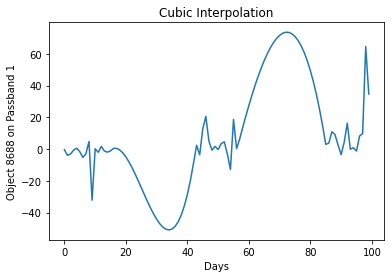

In [18]:
num = 265

id = lcvs["object_id"].unique()[int(num // 6)]
band = int(num % 6)

pl.plot(cubic_ipl[num]);
pl.title("Cubic Interpolation");
pl.ylabel(f"Object {id} on Passband {band}");
pl.xlabel("Days");

Figure 2: Cubic interpolation applied to passband 1 of object 8688. This is the same original data as shown in Figure 1. The data loses its original shape, but it looks more continuous than the linear interpolation. It also has larger minimas and maximas (goes up to 60 and down to -40) which does not match the original data. 

In [19]:
lerp = np.array(lerp)
lerp = lerp.flatten()

cubic_ipl = np.array(cubic_ipl)
cubic_ipl = cubic_ipl.flatten()

In [20]:
print(f"linear interpolation shape: {lerp.shape}")
print(f"cubic interpolation shape: {cubic_ipl.shape}")

linear interpolation shape: (4708800,)
cubic interpolation shape: (4696200,)


Both interpolators form the same shape, a 1-D array with all of the datapoints. Cubic lost some of the data due to some data not having enough datapoints (<4).

I have chosen to export both linear interpolation and cubic interpolation because I would like to test both results. They both have pros and cons, but I do not know which one will perform better.

In [21]:
np.save("/content/drive/MyDrive/MLTSA22/HW8/lin_ipl.npy", lerp) # linear interpolation
np.save("/content/drive/MyDrive/MLTSA22/HW8/cub_ipl.npy", cubic_ipl) # cubic interpolation